# Notebook 3: Training a Neural Network for Image Classification

In this notebook, we'll train a neural network to classify images rather than two-dimensional synthetic data. We'll also take a look at the components of a typical training pipeline in PyTorch, including datasets, data loaders, checkpointing, and logging.

The notebook is broken up as follows:

  1. [Setup](#setup)  
  2. [Data](#data)  
     2.1 [Datasets](#datasets)  
     2.2 [DataLoaders](#dataloaders)  
  3. [A Neural Network for Image Recognition](#nn)  
     3.1. [Defining the Network](#definition)  
     3.2  [Classification Loss](#loss)  
     3.3. [Checkpointing](#checkpoint)  
  4. [Putting It All Together: Training Loop](#train)  
     4.1 [A Basic Training Loop](#basic)  
     4.2 [Data Augmentation](#augmentation)  
     4.3 [Logging](#logging)  
     4.4 [GPU Acceleration](#gpu)

## __1.__ <a name="setup">Setup</a>


Make sure the needed packages are installed and utility code is in the right place.

In [16]:
# helper code from the course repository
!git clone https://github.com/interactiveaudiolab/course-deep-learning.git
%cd course-deep-learning/
# install common pacakges used for deep learning
%pip install -r requirements.txt

In [11]:
import time
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## __2.__ <a name="data">Data</a>

### __2.1__ <a name="datasets">Datasets</a>

In the previous two notebooks, we saw a variety of two-dimensional synthetic datasets. In this notebook, we'll be working with a pre-existing image dataset. Image data is inherently high-dimensional: each pixel corresponds to a single coordinate/dimension (grayscale), or holds three separate coordinates (RGB). For even small images (e.g. 32x32 pixels), this means our inputs can have thousands of dimensions! As a result, image datasets can be fairly large. Additionally, we may need to apply certain __transformations__ or __preprocessing__ steps to our image data before attempting to pass it to a neural network.

PyTorch and its corresponding image library, TorchVision, offer a number of utilities to streamline dataset storage, loading, and preprocessing. We'll start by using TorchVision to download the well-known MNIST dataset. This dataset contains 28x28-pixel images of handwritten digits, and our goal will be to predict the correct label given an image:

In [2]:
# make a new directory in which to download the MNIST dataset
data_dir = "./data/"

# download MNIST "test" dataset
mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# download MNIST "train" dataset and set aside a portion for validation
mnist_train_full = datasets.MNIST(data_dir, train=True, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

type(mnist_test), type(mnist_train), type(mnist_val)

(torchvision.datasets.mnist.MNIST,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

Our dataset is now held in three `torch.utils.data.Dataset` objects, each acting as an iterable container from which we can fetch input-label pairs. You should also now see a `data/` directory containing the MNIST dataset.

In [3]:
mnist_test[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F916C4A7580>, 7)

In [4]:
display(mnist_test[0][0])

In [5]:
len(mnist_test)

10000

It appears that our "test" dataset contains 10,000 entries, each of which is a tuple holding a `PIL.Image.Image` object and an integer label. Unfortunately, the neural networks we trained in the previous notebook require `torch.Tensor` inputs. We therefore need to apply some preprocessing to these image datasets before we can train a network.

TorchVision provides a `Transform` class for building and composing preprocessing stages that can be automatically applied to your image data. Here's an example:

Image label: 7
Transformed image shape: torch.Size([1, 28, 28])
Transformed image data: 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,  ...


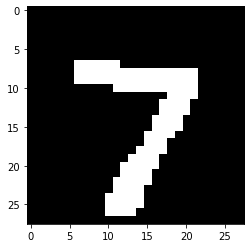

In [3]:
# we'll stack multiple transformations in a single object that will apply them in sequence
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # this is a built-in Transform object to convert images to tensors
    lambda x: x>0,  # this is our own transformation function for binarizing MNIST images
    lambda x: x.float(),  # this is our own transformation function for converting inputs to floating-point
])

# grab the first image-label pair from our "test" dataset
example_img, example_label = mnist_test[0]

# apply our sequence of transformations
transformed = transform(example_img)
print(f"Image label: {example_label}")
print("Transformed image shape:", transformed.shape)
print(f"Transformed image data: {(', '.join(str(p.item()) for p in transformed.flatten()))[:100]} ...")

# plot our image
plt.imshow(transformed.squeeze(), cmap='gray')
plt.show()

We can see that our transform converts MNIST images to floating-point binary vectors -- which we can feed to a neural network! In fact, we can bake our transform directly into our datasets so that it is applied automatically when we go to fetch data. To demonstrate, we'll re-initialize our datasets, this time reading directly from our `data/` folder rather than re-downloading:

In [4]:
# load MNIST "test" dataset from disk
mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=False, transform=transform)

# load MNIST "train" dataset from disk and set aside a portion for validation
mnist_train_full = datasets.MNIST(data_dir, train=True, download=False, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

example_img, example_label = mnist_test[0]
print(type(example_img), example_img.shape)

<class 'torch.Tensor'> torch.Size([1, 28, 28])


### __2.2__ <a name="dataloaders">DataLoaders</a>

Given that `torch.utils.data.Dataset` and its subclasses provide an iterable container from which we can fetch input-label pairs, we could go ahead and start traininng a network:

```
for x, y in myDataset:

    opt.zero_grad()

    outputs = myNetwork(x)
    
    loss = myLoss(outputs, y)
    loss.backward()
    
    opt.step()
    ...
```

However, we often want to load our data in __batches__ while training, typically in a random or __shuffled__ order. PyTorch provides a `DataLoader` class to handle the process of fetching data from a `Dataset` object, including shuffling, custom batch collation, and various random sampling schemes.

In [5]:
# we'll use a batch size of 60 for training our network
batch_size = 60

# initialize a DataLoader object for each dataset
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

# grab the first batch from one of our DataLoader objects
example_batch_img, example_batch_label = next(iter(train_dataloader))

# inputs and labels are batched together as tensor objects
print(f"Batch inputs shape: {example_batch_img.shape}, Batch labels shape: {example_batch_label.shape}")

Batch inputs shape: torch.Size([60, 1, 28, 28]), Batch labels shape: torch.Size([60])


## __3.__ <a name="nn">A Neural Network for Image Recognition</a>

### __3.1__ <a name="definition">Defining the Network</a>

Now that we've seen the data we'll be working with, it's time build a neural network capable of classifying handwritten digits. In the previous notebook, we created a neural network capable of turning two-dimensional inputs into one-dimensional (scalar) predictions. By contrast, our inputs will have 28x28 = 784 dimensions, and our network will have to predict one of ten possible labels (one for each digit 0-9). To accommodate these changes, we'll tweak our network as follows:

   1. We'll modify our network's first layer to take 784-dimensional inputs
   2. We'll use a larger intermediate layer to allow our network to learn complex decision functions
   3. We'll try out the ReLU (rectified linear unit) activation function 
   4. We'll have our network produce a 10-dimensional vector as output; the index of the largest value in this vector will be our predicted label (e.g. if the first entry has the largest value, our predicted digit will be 0).
   
<br/>
<center>
<img width="500px" src="https://drive.google.com/uc?export=view&id=1fCIzQT6smKorQAfFmJp7GsGBC9atMo4U"/>
</center>
<br/>


In [6]:
class MNISTNetwork(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # MNIST images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Linear(28*28, 1024)
        self.layer_2 = torch.nn.Linear(1024, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):

        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)  # create an array of flattened images with dimension (batch_size, num_pixels)

        # this time, we'll use the ReLU nonlinearity at each layer  
        x = self.relu(self.layer_1(x))
        x = self.layer_2(x)  # we'll avoid "squashing" our final outputs by omitting the sigmoid
        
        return x

### __3.2__ <a name="loss">Classification Loss</a>

In the previous notebook, we used mean squared error loss to train our neural network. While mean squared error performs well in a number of tasks, it is more common to use __categorical cross-entropy loss__ for multiclass classification. We can think of our network's output as a vector of ten "class scores," one per digit. In training our network, our goal is to make sure that given an input image, the correct class score "comes out on top." We might try to minimize the mean squared error between our network's normalized output and a __one-hot__ vector indexing the correct label

```
prediction = [0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.5, 0.1, 0.1]
target =     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
```

However, this objective does not necessarily correspond to our goal of maximizing the score of the target class while keeping all other scores low. Cross entropy loss generally does a better job of capturing this objective for multiclass classification, and its use can be considered equivalent to maximum-likelihood estimation under certain assumptions. We will use PyTorch's implementation, which provides an object capable of both computing the loss on pairs of tensors and computing gradients during the backward pass. We won't go into detail here, but for more info, check out the [official documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).


In [7]:
# a PyTorch cross-entropy loss object
loss_fn = torch.nn.CrossEntropyLoss()

# the loss object takes in a vector of class scores and a vector of target class indices
preds = torch.randn(batch_size, 10)  # make a batch of random "class score" vectors, each with 10 scores corresponding to digits
targets = torch.full((60,), 7).long()  # make a batch of target indices; here, we'll set 7 as the target for all predictions

# compute the loss for this batch; by default, CrossEntropyLoss will average over a batch to return a scalar
loss_fn(preds, targets)

tensor(2.9093)

### __3.3__ <a name="checkpoint">Checkpointing</a>

Before we begin training our model, we want to make sure we can save it in some format in case we experience a bug during training or want to use it again later. The process of saving snapshots of a model during training is often called __checkpointing__, and PyTorch offers utilities to make saving and loading models simple. For a neural network, saving a model really means saving its weights (parameters). All PyTorch models have a `.state_dict()` method that exposes their weights as named entries in a dictionary. Using this __state dictionary__ as an interface, we can easily save weights or overwrite them with ones we load from elsewhere. For more info, feel free to check out the [official documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).



In [8]:
# initialize a model
model = MNISTNetwork()
print("Names of network weights:", list(model.state_dict().keys()))

# save weights to disk
torch.save(model.state_dict(), "dummy_weights.pt")

# load weights from disk and overwrite network weights
model.load_state_dict(torch.load("dummy_weights.pt"))

Names of network weights: ['layer_1.weight', 'layer_1.bias', 'layer_2.weight', 'layer_2.bias']


<All keys matched successfully>

## __4.__ <a name="train">Putting It All Together: Training Loop</a>

### __4.1__ <a name="basic">A Basic Loop</a>
We're now ready to train a neural network to recognize handwritten digits from the MNIST dataset.

In [12]:
# initialize model
model = MNISTNetwork()

# initialize an optimizer to update our model's parameters during training
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# prepare to save checkpoints
model_path = "mnist_basic.pt"

# make a new directory in which to download the MNIST dataset
data_dir = "./data/"

# number of iterations through the dataset for training
epochs = 10

# we'll use a batch size of 60 for training our network
batch_size = 60

# initialize a Transform object to prepare our data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: x>0,
    lambda x: x.float(),
])

# load MNIST "test" dataset from disk
mnist_test = torchvision.datasets.MNIST(data_dir, train=False, download=False, transform=transform)

# load MNIST "train" dataset from disk and set aside a portion for validation
mnist_train_full = datasets.MNIST(data_dir, train=True, download=False, transform=transform)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train_full, [55000, 5000])

# initialize a DataLoader object for each dataset
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

# a PyTorch categorical cross-entropy loss object
loss_fn = torch.nn.CrossEntropyLoss()

# time training process
st = time.time()

# time to start training!
for epoch_idx, epoch in enumerate(range(epochs)):
    
    # keep track of best validation accuracy; if improved upon, save checkpoint
    best_acc = 0.0
    
    # loop through the entire dataset once per epoch
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        
        # clear gradients
        optimizer.zero_grad()
        
        # unpack data and labels
        x, y = batch
        
        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)
        
        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)
        
        # compute gradients and update model parameters
        loss.backward()
        optimizer.step()
        
        # update statistics
        train_loss += (loss * len(x))
        train_acc += (acc * len(x))
        train_total += len(x)
    
    train_loss /= train_total
    train_acc /= train_total
    
    # perform validation once per epoch
    val_loss = 0.0
    val_acc = 0.0
    val_total = 0
    model.eval()
    for batch_idx, batch in enumerate(val_dataloader):
        
        # don't compute gradients during validation
        with torch.no_grad():
        
            # unpack data and labels
            x, y = batch
        
            # generate predictions and compute loss
            output = model(x)
            loss = loss_fn(output, y)
        
            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)
            
            # update statistics
            val_loss += (loss * len(x))
            val_acc += (acc * len(x))
            val_total += len(x)
    
    val_loss /= val_total
    val_acc /= val_total
    print(f"Epoch {epoch_idx + 1}: val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")
    
    if val_acc > best_acc:
        
        best_acc = val_acc
        print(f"New best accuracy; saving model weights to {model_path}")
        torch.save(model.state_dict(), model_path)

print(f"Total training time (s): {time.time() - st}")
        
# load best weights
model.load_state_dict(torch.load(model_path))

# compute final performance on unseen test data. Typically, this is reserved for after the model development process
# in order to provide an unbiased estimate of the model's generalized accuracy
test_loss = 0.0
test_acc = 0.0
test_total = 0
model.eval()
for batch_idx, batch in enumerate(test_dataloader):

    # don't compute gradients during validation
    with torch.no_grad():

        # unpack data and labels
        x, y = batch

        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)

        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)

        # update statistics
        test_loss += (loss * len(x))
        test_acc += (acc * len(x))
        test_total += len(x)

test_loss /= test_total
test_acc /= test_total
print(f"test loss {test_loss :0.3f}, test acc {test_acc :0.3f}")

Epoch 1: val loss 0.469, val acc 0.879, train loss 0.953, train acc 0.794
New best accuracy; saving model weights to mnist_basic.pt
Epoch 2: val loss 0.370, val acc 0.897, train loss 0.416, train acc 0.886
New best accuracy; saving model weights to mnist_basic.pt
Epoch 3: val loss 0.329, val acc 0.904, train loss 0.352, train acc 0.899
New best accuracy; saving model weights to mnist_basic.pt
Epoch 4: val loss 0.307, val acc 0.909, train loss 0.321, train acc 0.907
New best accuracy; saving model weights to mnist_basic.pt
Epoch 5: val loss 0.290, val acc 0.917, train loss 0.298, train acc 0.914
New best accuracy; saving model weights to mnist_basic.pt
Epoch 6: val loss 0.276, val acc 0.919, train loss 0.280, train acc 0.918
New best accuracy; saving model weights to mnist_basic.pt
Epoch 7: val loss 0.262, val acc 0.922, train loss 0.264, train acc 0.923
New best accuracy; saving model weights to mnist_basic.pt
Epoch 8: val loss 0.252, val acc 0.925, train loss 0.250, train acc 0.927
Ne

### __4.2__ <a name="augmentation">Data Augmentation</a>

We've got a pretty accurate model, but there are plenty of deep learning tricks we can use to squeeze some extra performance. One common practice is __data augmentation__, in which random transformations are applied to inputs during training. This helps in two ways:
* Often, datasets are relatively small and imperfectly represent the popluation from which they are sampled. Data augmentation effectively expands the size of the dataset through sampling additional randomized variations of each instance.
* We typically want to train a model that is __robust__ against common real-world transformations of its inputs -- that is, a model whose predictions are __invariant__ under these transformations. Data augmentation exposes our model to a chosen set of transformations during training so that it can learn to "see past" them.

TorchVision provides a number of `Transform` objects designed to perform data augmentation, making it easy to apply transformations automatically when data is fetched from a `Dataset` object.

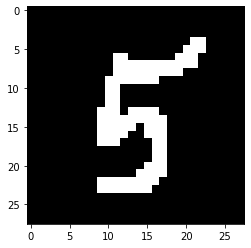

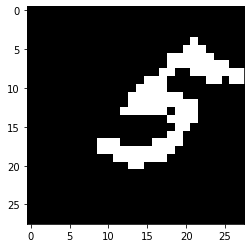

In [14]:
# fetch an image from the MNIST dataset
example_img, example_label = mnist_train[300]
plt.imshow(example_img.squeeze(), cmap='gray')
plt.show()

# perform a random affine transformation of an input (rotation, translation, shear)
affine_aug = torchvision.transforms.RandomAffine(degrees=(-30, 30), translate=(0.25, 0.25), shear=(-45, 45))
augmented = affine_aug(example_img)
plt.imshow(augmented.squeeze(), cmap='gray')
plt.show()

Because we're effectively increasing the size of the dataset, and due to the computation required to perform each transformation, training with data augmentation may take more time (as measured in both walltime and iterations). It's also worth noting that augmentations are typically applied to the training data only. While we won't go into detail at the moment, feel free to try training with any of the [augmentations offered by TorchVision](https://pytorch.org/vision/stable/transforms.html).

### __4.3__ <a name="logging">Logging</a>

In the above example, we print running summaries of our model's training performance in order to monitor its progress. This is somewhat clunky and limited - what if we want to plot accuracy in real time, visualize challenging instances, dynamically change what information is displayed, or document and compare across multiple training runs? All these tasks fall under the umbrella of __logging__, and once again, PyTorch provides utilities to simplify the process. We can use PyTorch's built-in TensorBoard support to configure and view training logs without the need for any external database or visualization software.

In [16]:
# here, we'll initialize TensorBoard. You should see an empty window in this cell, which will populate with
# graphs as soon as we run our training code below.
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
import datetime
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

# save all log data to a local directory
run_dir = "logs"

# to clear out TensorBoard and start totally fresh, we'll need to
# remove old logs by deleting them from the directory
!rm -rf ./logs/

# timestamp the logs for each run so we can sort through them 
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
logger = SummaryWriter(log_dir=Path(run_dir) / run_time)

# initialize model
model = MNISTNetwork()

# initialize an optimizer to update our model's parameters during training
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# prepare to save checkpoints
model_path = "mnist_again.pt"

# time to start training!
for epoch_idx, epoch in enumerate(range(epochs)):
    
    # keep track of best validation accuracy; if improved upon, save checkpoint
    best_acc = 0.0
    
    # loop through the entire dataset once per epoch
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        
        # clear gradients
        optimizer.zero_grad()
        
        # unpack data and labels
        x, y = batch
        
        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)
        
        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)
        
        # compute gradients and update model parameters
        loss.backward()
        optimizer.step()
        
        # update statistics
        train_loss += (loss * len(x))
        train_acc += (acc * len(x))
        train_total += len(x)
    
    train_loss /= train_total
    train_acc /= train_total
    
    # log progress to TensorBoard
    logger.add_scalar("train_loss", train_loss, epoch_idx)
    logger.add_scalar("train_acc", train_acc, epoch_idx)
    
    # perform validation once per epoch
    val_loss = 0.0
    val_acc = 0.0
    val_total = 0
    model.eval()
    for batch_idx, batch in enumerate(val_dataloader):
        
        # don't compute gradients during validation
        with torch.no_grad():
        
            # unpack data and labels
            x, y = batch
        
            # generate predictions and compute loss
            output = model(x)
            loss = loss_fn(output, y)
        
            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)
            
            # update statistics
            val_loss += (loss * len(x))
            val_acc += (acc * len(x))
            val_total += len(x)
    
    val_loss /= val_total
    val_acc /= val_total
    
    # log progress to TensorBoard
    logger.add_scalar("val_loss", val_loss, epoch_idx)
    logger.add_scalar("val_acc", val_acc, epoch_idx)
    
    if val_acc > best_acc:
        
        best_acc = val_acc
        print(f"New best accuracy; saving model weights to {model_path}")
        torch.save(model.state_dict(), model_path)

# load best weights
model.load_state_dict(torch.load(model_path))

# compute final performance on unseen test data. Typically, this is reserved for after the model development process
# in order to provide an unbiased estimate of the model's generalized accuracy
test_loss = 0.0
test_acc = 0.0
test_total = 0
model.eval()
for batch_idx, batch in enumerate(test_dataloader):

    # don't compute gradients during validation
    with torch.no_grad():

        # unpack data and labels
        x, y = batch

        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)

        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)

        # update statistics
        test_loss += (loss * len(x))
        test_acc += (acc * len(x))
        test_total += len(x)

test_loss /= test_total
test_acc /= test_total
print(f"test loss {test_loss :0.3f}, test acc {test_acc :0.3f}")

New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
New best accuracy; saving model weights to mnist_again.pt
test loss 0.220, test acc 0.935


We can also run TensorBoard from the terminal, in which case we can view the logs in a browser by navigating to the correct port on our `localhost`. In the example below, after running the command we would need to point our browser to `localhost:9999`

```
$ tensorboard --logdir /path/to/logging/directory/ --port 9999
```

If no port is given, TensorBoard will default to 6006. In fact, the logs from your experiment above should already be visible at `localhost:6006`. TensorBoard will continue serving on this port until the notebook kernel shuts down or you halt the terminal command (e.g. using `ctrl` + `c`), at which point you will not be able to view your logs until you re-start TensorBoard.

### __4.4__ <a name="gpu">GPU Acceleration</a>

Neural networks use many operations, such as matrix multiplication, that can be efficiently parallelized and run on modern GPUs (graphics processing units, sometimes called "video cards"). As a result, neural network training and inference can see drastic speedups when run on a suitable GPU. PyTorch offers this option for NVIDIA-manufactured GPUs through the [CUDA platform](https://pytorch.org/docs/stable/cuda.html), and provides a simple interface for moving data and computation between the CPU and GPU.

In practice, running machine learning code on a GPU may require you to check your device's compatibility and install various drivers; this can be quite a hassle. Luckily, [Google Colab](https://colab.research.google.com/) provides free (albeit limited) access to GPUs in a Jupyter-like notebook environment. If you're already running this code in Colab, you can access a GPU by going to `Runtime` > `Change runtime type`, setting `Hardware accelerator` to `GPU`, and clicking `Save`. Note that this will restart the notebook, meaning you will have to run your code again.

Below, we'll try our basic training loop again. This time, however, we'll move our network and data to the GPU, allowing for faster training and inference. While the difference between CPU and GPU may be relatively minor in this case, it can be massive for larger models and datasets.

In [13]:
# first, let's check if we can access a compatible GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# initialize model
model = MNISTNetwork()

# move our model (weights) to the GPU
model.to(device)

# initialize an optimizer to update our model's parameters during training
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# prepare to save checkpoints
model_path = "mnist_gpu.pt"

# time training process
st = time.time()

# time to start training!
for epoch_idx, epoch in enumerate(range(epochs)):
    
    # keep track of best validation accuracy; if improved upon, save checkpoint
    best_acc = 0.0
    
    # loop through the entire dataset once per epoch
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        
        # clear gradients
        optimizer.zero_grad()
        
        # unpack data and labels
        x, y = batch
        
        # move data to GPU
        x, y = x.to(device), y.to(device)
        
        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)
        
        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)
        
        # compute gradients and update model parameters
        loss.backward()
        optimizer.step()
        
        # update statistics
        train_loss += (loss * len(x))
        train_acc += (acc * len(x))
        train_total += len(x)
    
    train_loss /= train_total
    train_acc /= train_total
    
    # perform validation once per epoch
    val_loss = 0.0
    val_acc = 0.0
    val_total = 0
    model.eval()
    for batch_idx, batch in enumerate(val_dataloader):
        
        # don't compute gradients during validation
        with torch.no_grad():
        
            # unpack data and labels
            x, y = batch
            
            # move data to GPU
            x, y = x.to(device), y.to(device)
        
            # generate predictions and compute loss
            output = model(x)
            loss = loss_fn(output, y)
        
            # compute accuracy
            preds = output.argmax(dim=1)
            acc = preds.eq(y).sum().item()/len(y)
            
            # update statistics
            val_loss += (loss * len(x))
            val_acc += (acc * len(x))
            val_total += len(x)
    
    val_loss /= val_total
    val_acc /= val_total
    print(f"Epoch {epoch_idx + 1}: val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")
    
    if val_acc > best_acc:
        
        best_acc = val_acc
        print(f"New best accuracy; saving model weights to {model_path}")
        torch.save(model.state_dict(), model_path)

print(f"Total training time (s): {time.time() - st}")
        
# load best weights
model.load_state_dict(torch.load(model_path))

# compute final performance on unseen test data. Typically, this is reserved for after the model development process
# in order to provide an unbiased estimate of the model's generalized accuracy
test_loss = 0.0
test_acc = 0.0
test_total = 0
model.eval()
for batch_idx, batch in enumerate(test_dataloader):

    # don't compute gradients during validation
    with torch.no_grad():

        # unpack data and labels
        x, y = batch
        
        # move data to GPU
        x, y = x.to(device), y.to(device)

        # generate predictions and compute loss
        output = model(x)
        loss = loss_fn(output, y)

        # compute accuracy
        preds = output.argmax(dim=1)
        acc = preds.eq(y).sum().item()/len(y)

        # update statistics
        test_loss += (loss * len(x))
        test_acc += (acc * len(x))
        test_total += len(x)

test_loss /= test_total
test_acc /= test_total
print(f"test loss {test_loss :0.3f}, test acc {test_acc :0.3f}")

Epoch 1: val loss 0.477, val acc 0.882, train loss 0.965, train acc 0.785
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 2: val loss 0.370, val acc 0.894, train loss 0.421, train acc 0.885
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 3: val loss 0.334, val acc 0.905, train loss 0.355, train acc 0.898
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 4: val loss 0.309, val acc 0.910, train loss 0.323, train acc 0.907
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 5: val loss 0.289, val acc 0.918, train loss 0.300, train acc 0.913
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 6: val loss 0.275, val acc 0.922, train loss 0.281, train acc 0.919
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 7: val loss 0.260, val acc 0.926, train loss 0.265, train acc 0.923
New best accuracy; saving model weights to mnist_gpu.pt
Epoch 8: val loss 0.251, val acc 0.928, train loss 0.251, train acc 0.927
New best accurac